/tmp/ipython-input-4079122823.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, ax=ax_corr, palette='Blues_r')
/tmp/ipython-input-4079122823.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, ax=ax_rf, palette='Greens_r')
/tmp/ipython-input-4079122823.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, ax=ax_corr, palette='Blues_r')
/tmp/ipython-input-4079122823.py:59: FutureWarning: 

Passing `pale

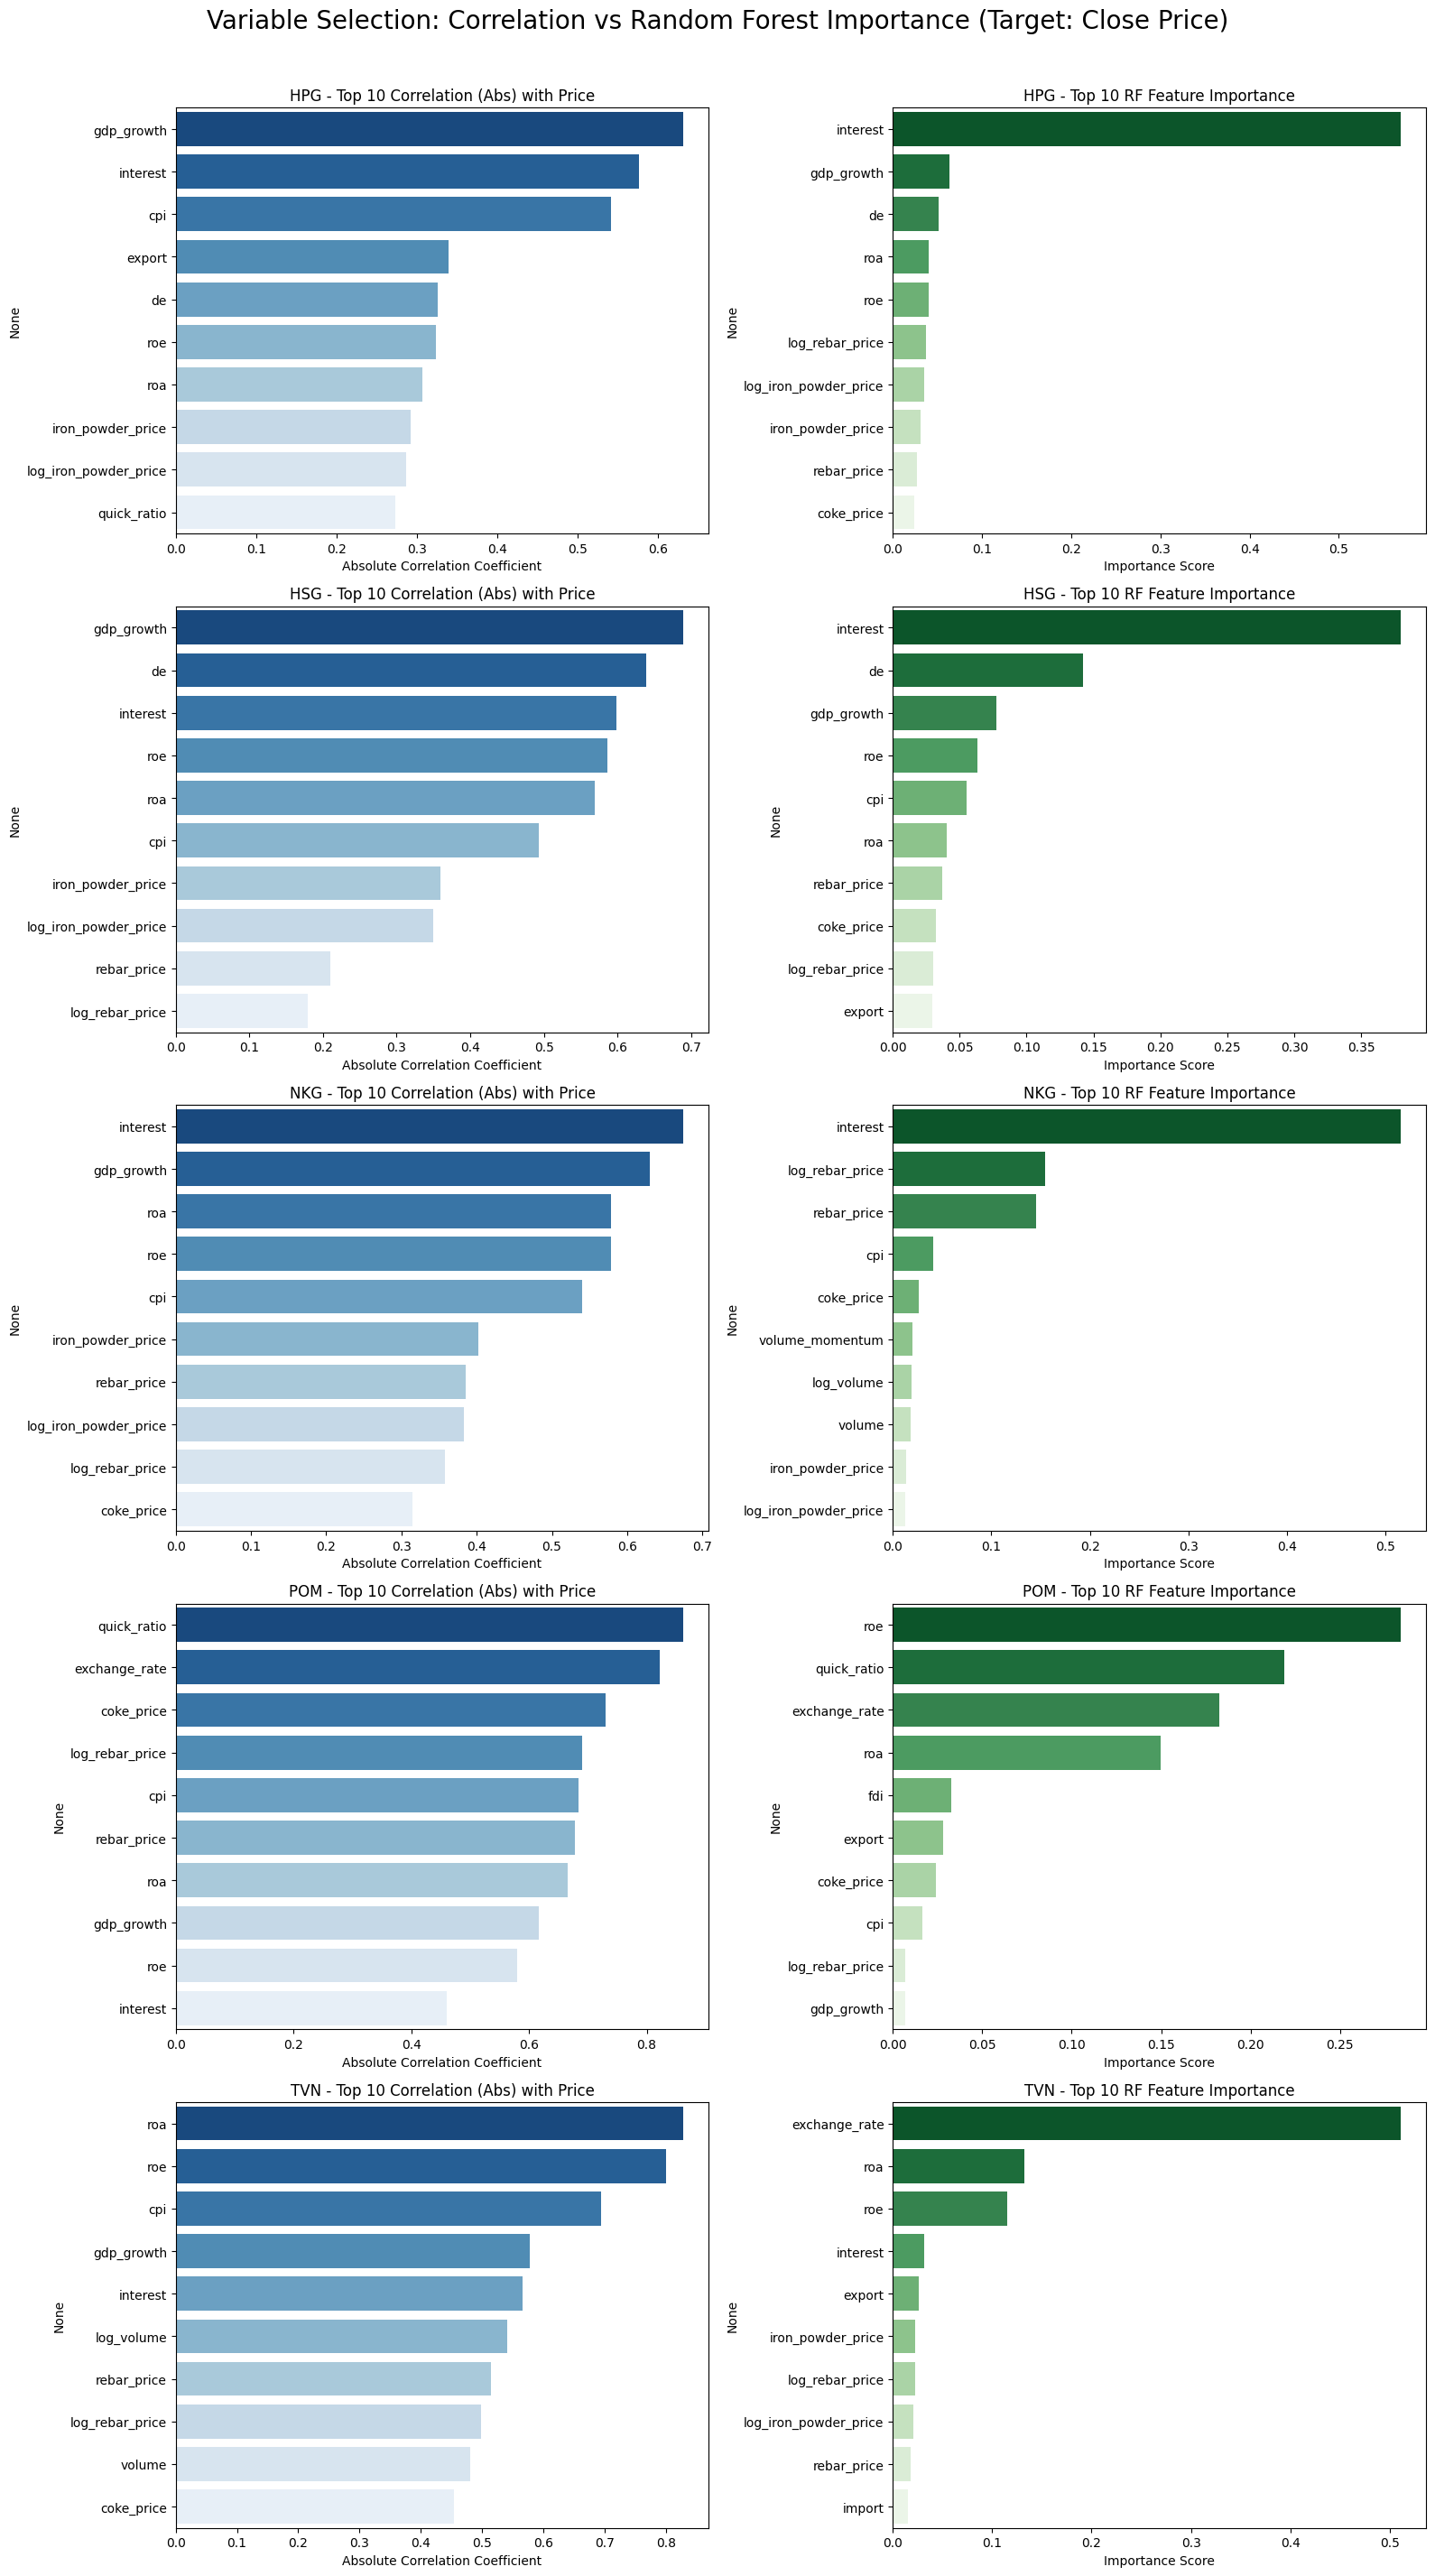

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Reload data just in case
df = pd.read_csv('synchronized_data.csv')

# Define Target
target = 'log_close'

# Define columns to exclude (Date, IDs, Target itself, and features derived directly from Price to avoid leakage)
# Note: PE, PB, and ratios involving 'price' directly correlate because Price is in the formula.
# To find "drivers" (causality/lead indicators), we should ideally exclude them,
# but usually, users want to see everything.
# I will exclude the obvious mathematical derivatives of Close to make the result useful.
cols_to_exclude = [
    'date', 'stock_id', 'close', 'daily_return', 'log_close', 'z_close',
    'log_pe', 'price_to_rebar', 'price_to_iron', 'price_to_coke',
    'price_x_interest', 'pe_to_roe', 'pe', 'pb'
]

# Get list of unique stocks
stock_ids = df['stock_id'].unique()

# Prepare figure
fig, axes = plt.subplots(len(stock_ids), 2, figsize=(16, 6 * len(stock_ids)))
fig.suptitle('Variable Selection: Correlation vs Random Forest Importance (Target: Close Price)', fontsize=20)

for i, stock in enumerate(stock_ids):
    # Filter data for specific stock
    sub_df = df[df['stock_id'] == stock].copy()

    # Prepare X and y
    # Drop excluded columns and select only numeric features
    X = sub_df.drop(columns=cols_to_exclude, errors='ignore').select_dtypes(include=[np.number])
    y = sub_df[target]

    # --- Method 1: Correlation Filter ---
    # Calculate absolute correlation with target
    correlations = X.apply(lambda x: x.corr(y)).abs().sort_values(ascending=False).head(10)

    # --- Method 2: Random Forest Feature Importance ---
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

    # --- Visualization ---
    ax_corr = axes[i][0] if len(stock_ids) > 1 else axes[0]
    ax_rf = axes[i][1] if len(stock_ids) > 1 else axes[1]

    # Plot Correlation
    sns.barplot(x=correlations.values, y=correlations.index, ax=ax_corr, palette='Blues_r')
    ax_corr.set_title(f'{stock} - Top 10 Correlation (Abs) with Price')
    ax_corr.set_xlabel('Absolute Correlation Coefficient')

    # Plot Random Forest
    sns.barplot(x=rf_importances.values, y=rf_importances.index, ax=ax_rf, palette='Greens_r')
    ax_rf.set_title(f'{stock} - Top 10 RF Feature Importance')
    ax_rf.set_xlabel('Importance Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to make room for suptitle
plt.show()

**HPG**

Starting Grid Search for ARIMA Order (p, 1, q)...
Best Order Found: (0, 1, 1) with AIC: -2288.75
Performing rolling forecast on Validation Set...

--- Validation Results (HPG) ---
RMSE: 0.3051
MAE: 0.2278
R2 Score: 0.9072


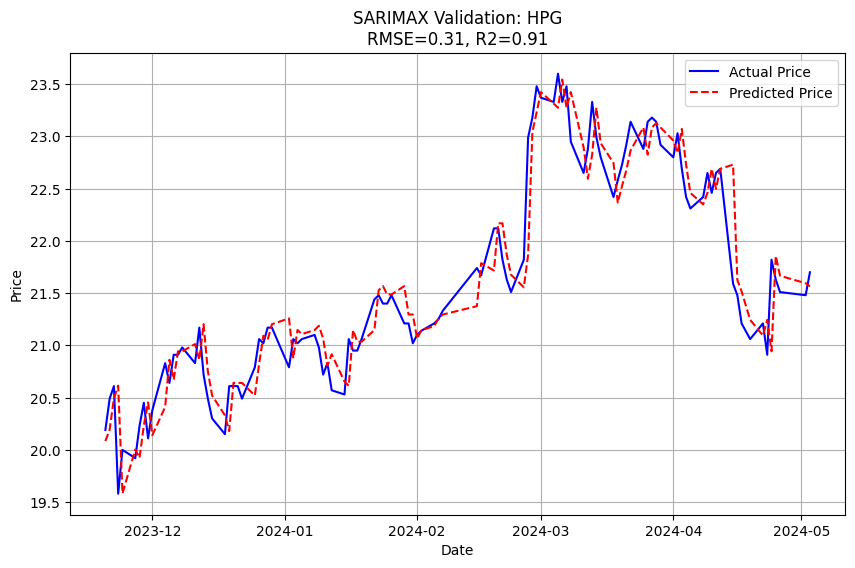

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

def run_sarimax_custom(filepath='synchronized_data.csv', stock_id='TVN'):
    # 1. Load Data
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['stock_id'] == stock_id].sort_values('date').reset_index(drop=True)

    # 2. Preprocessing
    # Log close
    df['log_close'] = np.log(df['close'])

    # Differencing (Data đã sai phân)
    df['diff_log_close'] = df['log_close'].diff()

    # Exogenous variables
    exog_cols = ['exchange_rate', 'roa', 'roe', 'interest', 'export', 'iron_powder_price', 'log_rebar_price']
    # exog_cols = ['interest', 'gdp_growth', 'rebar_price', 'exchange_rate']

    # Drop NaN created by differencing (first row)
    df_clean = df.dropna(subset=['diff_log_close']).reset_index(drop=True)

    # 3. Split Data (70% Train, 15% Val, 15% Test)
    n = len(df_clean)
    train_end = int(n * 0.70)
    val_end = int(n * 0.85)

    train_df = df_clean.iloc[:train_end]
    val_df = df_clean.iloc[train_end:val_end]
    test_df = df_clean.iloc[val_end:]

    # Prepare Endog and Exog
    y_train = train_df['diff_log_close']
    y_val = val_df['diff_log_close']
    y_test = test_df['diff_log_close']

    X_train = train_df[exog_cols]
    X_val = val_df[exog_cols]
    X_test = test_df[exog_cols]

    # Scale Exog
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=exog_cols, index=X_train.index)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=exog_cols, index=X_val.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=exog_cols, index=X_test.index)

    # 4. Grid Search for Order (Simple Fallback)
    # We use d=0 because data is already differenced
    best_aic = np.inf
    best_order = (1, 0, 1) # Default

    print("Starting Grid Search for ARIMA Order (p, 1, q)...")
    for p in range(3):
        for q in range(3):
            try:
                model = SARIMAX(y_train, exog=X_train_scaled, order=(p, 1, q),
                                enforce_stationarity=False, enforce_invertibility=False)
                res = model.fit(disp=False)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p, 1, q)
            except:
                continue

    print(f"Best Order Found: {best_order} with AIC: {best_aic:.2f}")

    # 5. Fit Best Model on Train
    final_model = SARIMAX(y_train, exog=X_train_scaled, order=best_order,
                          enforce_stationarity=False, enforce_invertibility=False)
    res_fitted = final_model.fit(disp=False)

    # 6. Validation (Rolling Forecast)
    # Since we model differences, prediction is Diff_Log_Price
    # We will do 1-step ahead forecast for the validation set using actual history

    print("Performing rolling forecast on Validation Set...")
    val_preds_diff = []

    # History starts with training data
    history_endog = list(y_train)
    history_exog = list(X_train_scaled.values)

    # We loop through validation set
    # Optimally, we would re-fit, but for speed we just filter/predict using updated history or just use the model object
    # For statsmodels, we can use 'append' or just re-create model.
    # To save time in this environment, we'll use the fixed parameters from training and just apply to new data (filter method)
    # Or simpler: Use predict with dynamic=False if we pass the whole series?
    # No, strictly rolling means using info up to t-1.
    # Statsmodels .predict(start, end, exog) uses the data in 'endog' attached to the model for lags.
    # So we need to extend the model results.

    # Efficient way: create a model with (train + val), set params, then predict validation part
    full_exog = pd.concat([X_train_scaled, X_val_scaled])
    full_endog = pd.concat([y_train, y_val])

    # Re-setup model with full data but fixed params
    model_val = SARIMAX(full_endog, exog=full_exog, order=best_order,
                        enforce_stationarity=False, enforce_invertibility=False)
    res_val = model_val.filter(res_fitted.params) # Apply trained params to new data

    # Predict for the validation indices
    # Indices in statsmodels are 0-based. Train ends at len(y_train)-1.
    # Val starts at len(y_train).
    val_start = len(y_train)
    val_end_idx = len(y_train) + len(y_val) - 1

    pred_res = res_val.get_prediction(start=val_start, end=val_end_idx, exog=X_val_scaled)
    pred_diff = pred_res.predicted_mean

    # 7. Reconstruct Prices
    # Actual previous log close is needed.
    # The 'diff_log_close' at time t is log(P_t) - log(P_{t-1})
    # So log(P_t)_pred = log(P_{t-1})_actual + diff_pred_t
    # We need the vector of "previous log prices" corresponding to validation set.

    # Get log_close from original df_clean
    # The validation part corresponds to indices in df_clean: train_end to val_end-1
    # We need lag-1 log_close.
    # df_clean['log_close'] indices: 0..N-1
    # Validation indices: train_end ... val_end-1
    # Previous values indices: train_end-1 ... val_end-2

    prev_log_close = df_clean.iloc[train_end-1 : val_end-1]['log_close'].values

    # Reconstruct
    pred_log_close = prev_log_close + pred_diff.values
    pred_price = np.exp(pred_log_close)

    # Actual prices for validation
    actual_price = df_clean.iloc[train_end : val_end]['close'].values
    actual_dates = df_clean.iloc[train_end : val_end]['date'].values

    # 8. Evaluation
    rmse = np.sqrt(mean_squared_error(actual_price, pred_price))
    mae = mean_absolute_error(actual_price, pred_price)
    r2 = r2_score(actual_price, pred_price)

    print(f"\n--- Validation Results ({stock_id}) ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(actual_dates, actual_price, label='Actual Price', color='blue')
    plt.plot(actual_dates, pred_price, label='Predicted Price', color='red', linestyle='--')
    plt.title(f'SARIMAX Validation: {stock_id}\nRMSE={rmse:.2f}, R2={r2:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    plt.show()

run_sarimax_custom()

--- VALIDATION RESULTS (70% Train / 15% Val) ---
               Model      RMSE       MAE  R2 Score
2                SVR  0.480646  0.369837  0.766056
0      Random Forest  0.598297  0.445560  0.637510
1  Gradient Boosting  0.768491  0.561009  0.401947


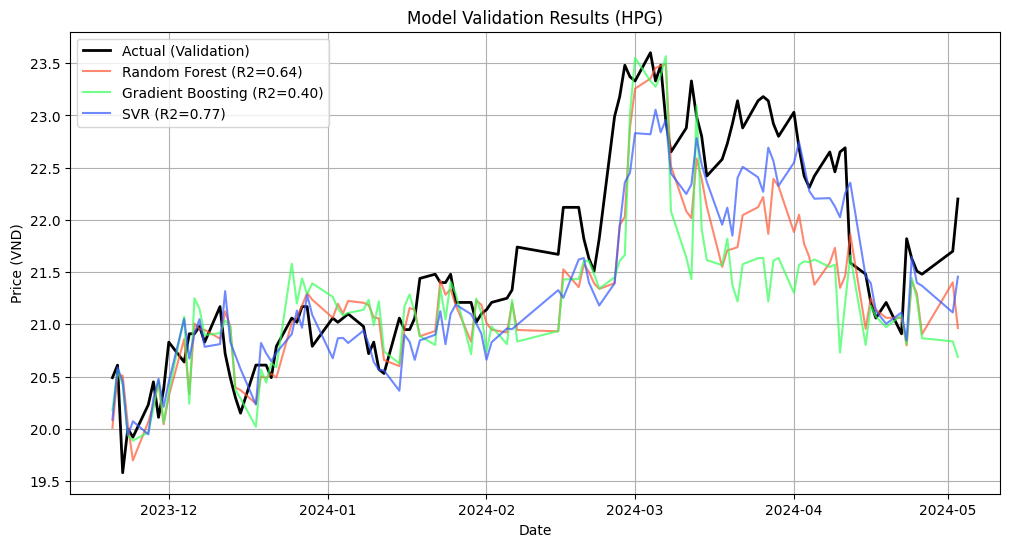

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import warnings

warnings.filterwarnings('ignore')

# 1. Load Data
try:
    df = pd.read_csv('synchronized_data.csv')
except FileNotFoundError:
    print("Error: File not found.")
    exit()

# Preprocessing for TVN
data = df[df['stock_id'] == 'TVN'].copy()
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date').reset_index(drop=True)

# Create features
data['log_close'] = np.log(data['close'])
data['log_volume'] = np.log(data['volume'])

# Target: Next day's log close
data['target_log'] = np.log(data['close']).shift(-1)

# Lags
lags = 3
for i in range(lags):
    data[f'log_close_lag_{i}'] = data['log_close'].shift(i)
    data[f'log_volume_lag_{i}'] = data['log_volume'].shift(i)

features = [f'log_close_lag_{i}' for i in range(lags)] + \
           [f'log_volume_lag_{i}' for i in range(lags)] + \
           ['exchange_rate', 'roa', 'roe', 'interest', 'export', 'iron_powder_price', 'log_rebar_price']

# Clean NaN
data_clean = data.dropna().reset_index(drop=True)

# 2. SPLIT DATA (70% Train, 15% Val, 15% Test)
n = len(data_clean)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

# Train Set
X_train = data_clean.iloc[:train_end][features].values
y_train = data_clean.iloc[:train_end]['target_log'].values

# Validation Set
X_val = data_clean.iloc[train_end:val_end][features].values
y_val = data_clean.iloc[train_end:val_end]['target_log'].values
val_dates = data_clean.iloc[train_end:val_end]['date']

# Test Set (Reserved)
X_test = data_clean.iloc[val_end:][features].values
y_test = data_clean.iloc[val_end:]['target_log'].values

# 3. Scaling (Fit on Train, Transform Val/Test)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test) # Not used in this validation step

# 4. Models
results = {}

# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
pred_rf_log = rf.predict(X_val)
results['Random Forest'] = np.exp(pred_rf_log)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train, y_train)
pred_gb_log = gb.predict(X_val)
results['Gradient Boosting'] = np.exp(pred_gb_log)

# SVR (Uses Scaled Data)
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svr.fit(X_train_scaled, y_train)
pred_svr_log = svr.predict(X_val_scaled)
results['SVR'] = np.exp(pred_svr_log)

# 5. Evaluation
y_val_real = np.exp(y_val)
metrics = []

for name, preds in results.items():
    rmse = np.sqrt(mean_squared_error(y_val_real, preds))
    mae = mean_absolute_error(y_val_real, preds)
    r2 = r2_score(y_val_real, preds)
    metrics.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2 Score': r2})

metrics_df = pd.DataFrame(metrics).sort_values('R2 Score', ascending=False)
print("--- VALIDATION RESULTS (70% Train / 15% Val) ---")
print(metrics_df)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(val_dates, y_val_real, label='Actual (Validation)', color='black', linewidth=2)
colors = ['#FF5733', '#33FF57', '#3357FF']
for i, (name, preds) in enumerate(results.items()):
    r2 = metrics_df[metrics_df['Model'] == name]['R2 Score'].values[0]
    plt.plot(val_dates, preds, label=f"{name} (R2={r2:.2f})", color=colors[i], alpha=0.7)

plt.title('Model Validation Results (TVN)')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.grid(True)tvn
plt.show()

All features found.
Train shape: (486, 40, 6)
Val shape:   (104, 40, 6)
Test shape:  (105, 40, 6)
Training LSTM...
Training RNN...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step

--- VALIDATION RESULTS (Price VND) ---
  Model      RMSE       MAE        R2
0  LSTM  1.416708  1.173442 -1.020765
1   RNN  1.470106  1.220478 -1.175967


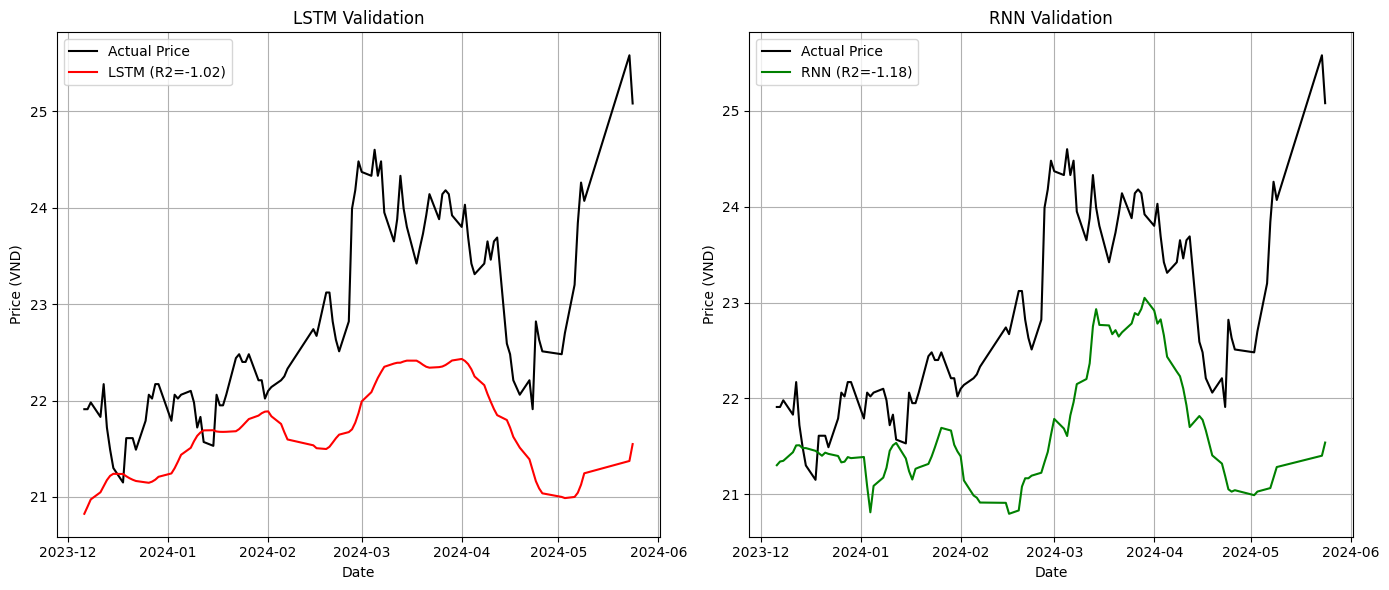

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings('ignore')

# 1. Load Data
df = pd.read_csv('synchronized_data.csv')
df['date'] = pd.to_datetime(df['date'])
df_tvn = df[df['stock_id'] == 'TVN'].sort_values('date').reset_index(drop=True)

# 2. Feature Setup
# Ensure we include the target (log_close) as the first feature for easier sequence creation
# User listed: 'gdp_growth', 'log_volume', 'log_rebar_price', 'interest', 'exchange_rate'
# We add 'log_close' to the front.
features = ['exchange_rate', 'roa', 'roe', 'interest', 'export', 'iron_powder_price', 'log_rebar_price']

''' Phúc said: "Các biến vĩ mô với chỉ số tài chính không có tính chất theo chuỗi thời gian mà được fill forward
                nên là khi bỏ các biến này và chỉ chạy các biến mang tính chất time-series thì độ giải thích sẽ cao hơn (ko quá đáng kể)"
                '''
# còn bữa chạy ra độ ý nghĩa cao là do quên bỏ log_close vô feature... ae thông cảm :v
# features = ['log_close', 'volume', 'log_volume']

# Check if columns exist
missing_cols = [c for c in features if c not in df_tvn.columns]
if missing_cols:
    print(f"Missing columns: {missing_cols}")
    # Fallback or create if possible? log_close is likely there.
    # df_hpg['log_close'] should be there from previous steps or original file.
    # Original file has 'log_close'.
else:
    print("All features found.")

data = df_tvn[features].values

# 3. Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 4. Create Sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        # Target is the NEXT value of the first column (log_close)
        # So at index i, sequence is i to i+seq_length-1. Target is at i+seq_length.
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 40
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# 5. Split Data (70% Train, 15% Val, 15% Test)
n_samples = len(X)
train_end = int(n_samples * 0.70)
val_end = int(n_samples * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

# 6. Model Building
input_shape = (X_train.shape[1], X_train.shape[2])

def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_rnn(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 7. Training
print("Training LSTM...")
lstm = build_lstm(input_shape)
# Use X_val for validation_data
lstm.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=0)

print("Training RNN...")
rnn = build_rnn(input_shape)
rnn.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=0)

# 8. Evaluation Helper
def evaluate_and_inverse(model, X_set, y_set, scaler):
    # Predict (scaled)
    pred_scaled = model.predict(X_set) # (N, 1)

    # Prepare dummy matrix for inverse transform
    # We need to fill other features with 0 (or anything) since scaler expects (N, n_features)
    # y_set is (N,)

    # Inverse Target (y_set)
    dummy_y = np.zeros((len(y_set), scaled_data.shape[1]))
    dummy_y[:, 0] = y_set
    inv_y = scaler.inverse_transform(dummy_y)[:, 0] # This is log_close

    # Inverse Prediction
    dummy_pred = np.zeros((len(pred_scaled), scaled_data.shape[1]))
    dummy_pred[:, 0] = pred_scaled.flatten()
    inv_pred = scaler.inverse_transform(dummy_pred)[:, 0] # This is log_close

    # Convert to Price (exp)
    real_price = np.exp(inv_y)
    pred_price = np.exp(inv_pred)

    # Metrics
    rmse = np.sqrt(mean_squared_error(real_price, pred_price))
    mae = mean_absolute_error(real_price, pred_price)
    r2 = r2_score(real_price, pred_price)

    return real_price, pred_price, rmse, mae, r2

# Evaluate on Validation Set
lstm_real, lstm_pred, lstm_rmse, lstm_mae, lstm_r2 = evaluate_and_inverse(lstm, X_val, y_val, scaler)
rnn_real, rnn_pred, rnn_rmse, rnn_mae, rnn_r2 = evaluate_and_inverse(rnn, X_val, y_val, scaler)

# 9. Results
results_df = pd.DataFrame([
    {'Model': 'LSTM', 'RMSE': lstm_rmse, 'MAE': lstm_mae, 'R2': lstm_r2},
    {'Model': 'RNN',  'RMSE': rnn_rmse,  'MAE': rnn_mae,  'R2': rnn_r2}
])

print("\n--- VALIDATION RESULTS (Price VND) ---")
print(results_df)

# 10. Plotting
val_dates = df_tvn['date'].iloc[SEQ_LENGTH + train_end : SEQ_LENGTH + val_end].values

plt.figure(figsize=(14, 6))

# LSTM Plot
plt.subplot(1, 2, 1)
plt.plot(val_dates, lstm_real, label='Actual Price', color='black')
plt.plot(val_dates, lstm_pred, label=f'LSTM (R2={lstm_r2:.2f})', color='red')
plt.title('LSTM Validation')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.grid(True)

# RNN Plot
plt.subplot(1, 2, 2)
plt.plot(val_dates, rnn_real, label='Actual Price', color='black')
plt.plot(val_dates, rnn_pred, label=f'RNN (R2={rnn_r2:.2f})', color='green')
plt.title('RNN Validation')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

**tunning ML**

Kết quả đánh giá mô hình tối ưu trên tập VALIDATION:
Random Forest: R2 (VAL) = 0.6375 | Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}
Gradient Boosting: R2 (VAL) = 0.4047 | Best Params: {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 7, 'learning_rate': 0.2}
SVR: R2 (VAL) = 0.8806 | Best Params: {'kernel': 'rbf', 'gamma': 0.001, 'epsilon': 0.001, 'C': 100}


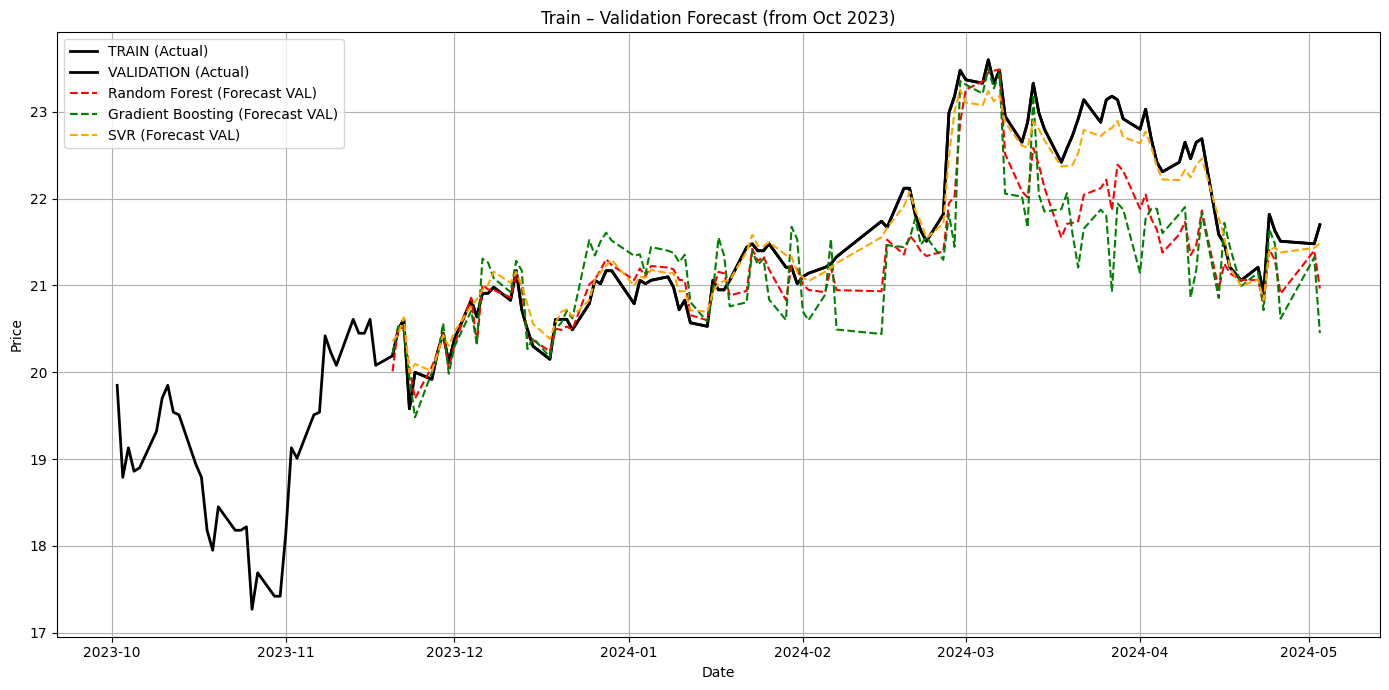

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# 1. Load & Preprocess Data
df = pd.read_csv('synchronized_data.csv')
data = df[df['stock_id'] == 'TVN'].copy()
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date').reset_index(drop=True)

# Features & Target
data['log_close'] = np.log(data['close'])
data['log_volume'] = np.log(data['volume'])
data['target_log'] = np.log(data['close']).shift(-1)

lags = 3
for i in range(lags):
    data[f'log_close_lag_{i}'] = data['log_close'].shift(i)
    data[f'log_volume_lag_{i}'] = data['log_volume'].shift(i)

features = [f'log_close_lag_{i}' for i in range(lags)] + \
           [f'log_volume_lag_{i}' for i in range(lags)] + \
           ['exchange_rate', 'roa', 'roe', 'interest', 'export', 'iron_powder_price', 'log_rebar_price']

data_clean = data.dropna().reset_index(drop=True)

# 2. Split Data into Train / Val / Test
n = len(data_clean)
train_end = int(n * 0.70)          # 70% train
val_end = int(n * 0.85)            # 15% val, 15% test

X_train = data_clean.iloc[:train_end][features].values
y_train = data_clean.iloc[:train_end]['target_log'].values

X_val = data_clean.iloc[train_end:val_end][features].values
y_val = data_clean.iloc[train_end:val_end]['target_log'].values

X_test = data_clean.iloc[val_end:][features].values
y_test = data_clean.iloc[val_end:]['target_log'].values

# 3. Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 4. Hyperparameter Tuning using only TRAIN (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=3)

rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

gb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

svr_params = {
    'C': [0.1, 1, 10, 100, 500, 1000],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'epsilon': [0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

models = [
    ('Random Forest', RandomForestRegressor(random_state=42, n_jobs=-1), rf_params),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42), gb_params),
    ('SVR', SVR(), svr_params)
]

print("Kết quả đánh giá mô hình tối ưu trên tập VALIDATION:")
for name, model, params in models:

    search = RandomizedSearchCV(
        model,
        params,
        n_iter=20,
        cv=tscv,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train_scaled, y_train)
    best_model = search.best_estimator_

    pred_val_log = best_model.predict(X_val_scaled)
    r2_val = r2_score(np.exp(y_val), np.exp(pred_val_log))

    print(f"{name}: R2 (VAL) = {r2_val:.4f} | Best Params: {search.best_params_}")

# --------------------------
#  TRỰC QUAN HÓA TRAIN – VAL
# --------------------------

plot_df = data_clean[['date', 'close']].copy()
predictions_val = {}

for name, model, params in models:
    search = RandomizedSearchCV(
        model,
        params,
        n_iter=20,
        cv=tscv,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train_scaled, y_train)
    best_model = search.best_estimator_

    pred_val_log = best_model.predict(X_val_scaled)
    pred_val = np.exp(pred_val_log)

    predictions_val[name] = pred_val


# Biểu đồ 2: Chỉ từ 10/2023
start_date = pd.Timestamp("2023-10-01")
mask = plot_df['date'] >= start_date

# ---------------------------------------
# TÙY CHỈNH MÀU CHO TỪNG ĐƯỜNG
# ---------------------------------------
color_map = {
    'TRAIN': 'black',
    'VAL': 'black',
    'Random Forest': 'red',
    'Gradient Boosting': 'green',
    'SVR': 'orange'
}
# ---------------------------------------

plt.figure(figsize=(14, 7))

# TRAIN (Actual)
plt.plot(
    plot_df['date'][:val_end][mask[:val_end]],
    plot_df['close'][:val_end][mask[:val_end]],
    label='TRAIN (Actual)',
    linewidth=2,
    color=color_map['TRAIN']
)

# VALIDATION (Actual)
plt.plot(
    plot_df['date'][train_end:val_end][mask[train_end:val_end]],
    plot_df['close'][train_end:val_end][mask[train_end:val_end]],
    label='VALIDATION (Actual)',
    linewidth=2,
    color=color_map['VAL']
)

# FORECASTS for each model
for name, pred_val in predictions_val.items():
    plt.plot(
        plot_df['date'][train_end:val_end][mask[train_end:val_end]],
        pred_val[mask[train_end:val_end]],
        linestyle='--',
        label=f'{name} (Forecast VAL)',
        color=color_map[name] if name in color_map else None
    )

plt.title("Train – Validation Forecast (from Oct 2023)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Kết quả đánh giá mô hình tối ưu trên tập VALIDATION:")
for name, model, params in models:

    search = RandomizedSearchCV(
        model,
        params,
        n_iter=20,
        cv=tscv,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train_scaled, y_train)
    best_model = search.best_estimator_

    # Dự báo log
    pred_val_log = best_model.predict(X_val_scaled)

    # Chuyển về giá trị thực
    pred_val = np.exp(pred_val_log)
    y_val_real = np.exp(y_val)

    # Tính RMSE, MAE, R2
    rmse_val = np.sqrt(mean_squared_error(y_val_real, pred_val))
    mae_val = mean_absolute_error(y_val_real, pred_val)
    r2_val = r2_score(y_val_real, pred_val)

    # In kết quả
    print(f"{name}:")
    print(f"   RMSE (VAL) = {rmse_val:.4f}")
    print(f"   MAE  (VAL) = {mae_val:.4f}")
    print(f"   R2   (VAL) = {r2_val:.4f}")
    print(f"   Best Params = {search.best_params_}")
    print("-" * 60)

Kết quả đánh giá mô hình tối ưu trên tập VALIDATION:
Random Forest:
   RMSE (VAL) = 0.5983
   MAE  (VAL) = 0.4456
   R2   (VAL) = 0.6375
   Best Params = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}
------------------------------------------------------------
Gradient Boosting:
   RMSE (VAL) = 0.7668
   MAE  (VAL) = 0.5858
   R2   (VAL) = 0.4047
   Best Params = {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 7, 'learning_rate': 0.2}
------------------------------------------------------------
SVR:
   RMSE (VAL) = 0.3433
   MAE  (VAL) = 0.2570
   R2   (VAL) = 0.8806
   Best Params = {'kernel': 'rbf', 'gamma': 0.001, 'epsilon': 0.001, 'C': 100}
------------------------------------------------------------


**tunning DL**

Train: (486, 40, 6)  Val: (104, 40, 6)  Test: (105, 40, 6)

===== TUNING LSTM =====
Testing LSTM: units=32, dr=0.1, lr=0.001, bs=16, ep=40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Testing LSTM: units=32, dr=0.1, lr=0.001, bs=16, ep=60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Testing LSTM: units=32, dr=0.1, lr=0.001, bs=32, ep=40


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Testing LSTM: units=32, dr=0.1, lr=0.001, bs=32, ep=60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Testing LSTM: units=32, dr=0.1, lr=0.0005, bs=16, ep=40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Testing LSTM: units=32, dr=0.1, lr=0.0005, bs=16, ep=60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Testing LSTM: units=32, dr=0.1, lr=0.0005, bs=32, ep=40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Testing LSTM: units=32, dr=0.1, lr=0.0005, bs=32, ep=60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Testing LSTM: units=32, dr=0.2, lr=0.001, bs=16, ep=40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Testing LSTM: units=32, dr=0.2, lr=0.001, bs=16, ep=60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
Testing LSTM: units=32, dr=0.2, lr=0.001, bs=32, ep=40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Testing LSTM: units=32, dr=0.2, lr=0.001, bs=32, ep=60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Testing LSTM: units=32, dr=0.2, lr=0.0005, bs=16, ep=40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step
Testing LSTM: un

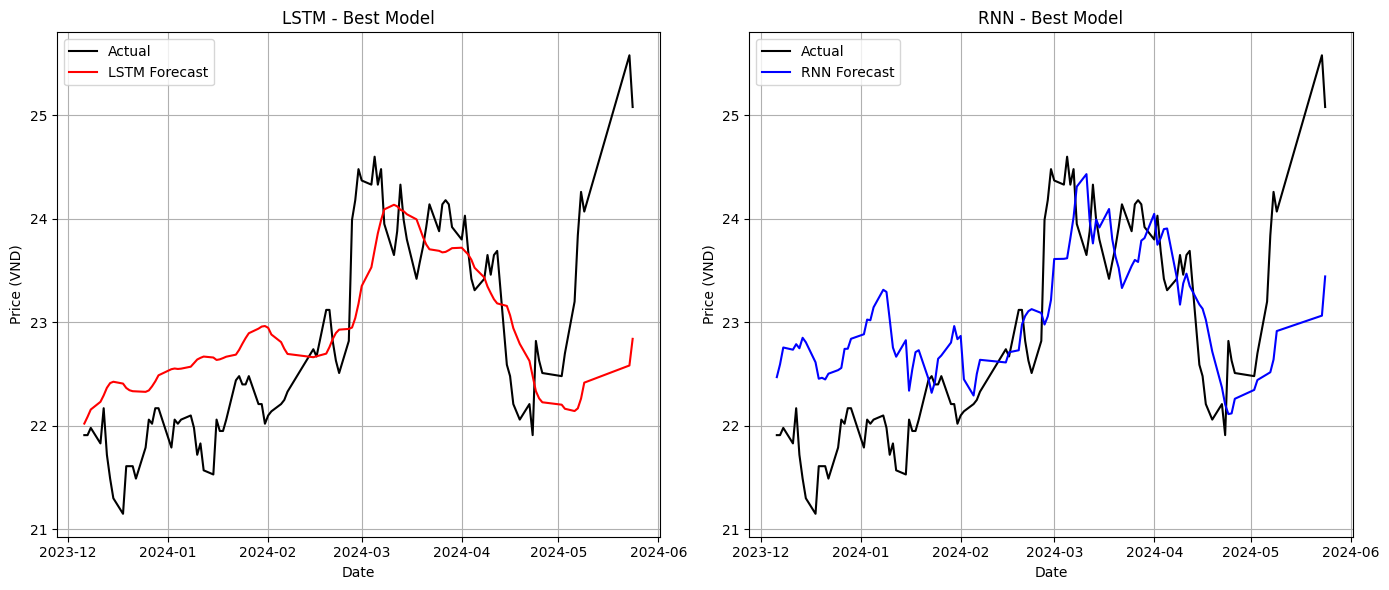

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# ===========================================
# 1. Load Data
# ===========================================
df = pd.read_csv('synchronized_data.csv')
df['date'] = pd.to_datetime(df['date'])
df_tvn = df[df['stock_id'] == 'TVN'].sort_values('date').reset_index(drop=True)

# 2. Features
features = ['exchange_rate', 'roa', 'roe', 'interest', 'export', 'iron_powder_price', 'log_rebar_price']

data = df_tvn[features].values

# ===========================================
# 3. Scaling
# ===========================================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# ===========================================
# 4. Create Sequences
# ===========================================
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # log_close
    return np.array(X), np.array(y)

SEQ_LENGTH = 40
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# ===========================================
# 5. Train-Validation-Test Split
# ===========================================
n_samples = len(X)
train_end = int(n_samples * 0.70)
val_end   = int(n_samples * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

input_shape = (X_train.shape[1], X_train.shape[2])

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

# ===========================================
# 6. Define Model Builders
# ===========================================
def build_lstm_model(num_units, dropout_rate, lr):
    model = Sequential()
    model.add(LSTM(num_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(num_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model

def build_rnn_model(num_units, dropout_rate, lr):
    model = Sequential()
    model.add(SimpleRNN(num_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(num_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model

# ===========================================
# 7. Hyperparameter Search Space
# ===========================================
param_grid = {
    "num_units": [32, 50, 64],
    "dropout": [0.1, 0.2, 0.3],
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "epochs": [40, 60]
}

# ===========================================
# 8. Train + Validation Evaluation
# ===========================================
def evaluate_and_inverse(model, X_set, y_set, scaler):
    pred_scaled = model.predict(X_set)

    dummy_y = np.zeros((len(y_set), scaled_data.shape[1]))
    dummy_y[:, 0] = y_set
    inv_y = scaler.inverse_transform(dummy_y)[:, 0]

    dummy_pred = np.zeros((len(pred_scaled), scaled_data.shape[1]))
    dummy_pred[:, 0] = pred_scaled.flatten()
    inv_pred = scaler.inverse_transform(dummy_pred)[:, 0]

    real_price = np.exp(inv_y)
    pred_price = np.exp(inv_pred)

    rmse = np.sqrt(mean_squared_error(real_price, pred_price))
    mae = mean_absolute_error(real_price, pred_price)
    r2 = r2_score(real_price, pred_price)

    return real_price, pred_price, rmse, mae, r2


def tune_model(build_fn, model_name):
    best_r2 = -999
    best_params = {}
    best_model = None

    print(f"\n===== TUNING {model_name} =====")

    for units in param_grid['num_units']:
        for dr in param_grid['dropout']:
            for lr in param_grid['lr']:
                for bs in param_grid['batch_size']:
                    for ep in param_grid['epochs']:

                        print(f"Testing {model_name}: units={units}, dr={dr}, lr={lr}, bs={bs}, ep={ep}")

                        model = build_fn(units, dr, lr)
                        model.fit(X_train, y_train, batch_size=bs, epochs=ep,
                                  validation_data=(X_val, y_val), verbose=0)

                        _, _, rmse, mae, r2 = evaluate_and_inverse(model, X_val, y_val, scaler)

                        if r2 > best_r2:
                            best_r2 = r2
                            best_params = dict(units=units, dropout=dr, lr=lr, batch=bs, epochs=ep)
                            best_model = model

    print(f"\nBEST {model_name} PARAMS:", best_params)
    print(f"BEST {model_name} R2 on Validation:", best_r2)

    return best_model, best_params, best_r2

# ===========================================
# 9. Run Tuning for LSTM & RNN
# ===========================================
best_lstm, lstm_params, lstm_r2 = tune_model(build_lstm_model, "LSTM")
best_rnn,  rnn_params,  rnn_r2  = tune_model(build_rnn_model, "RNN")

# ===========================================
# 10. Final Evaluation on Validation
# ===========================================
lstm_real, lstm_pred, lstm_rmse, lstm_mae, lstm_r2 = evaluate_and_inverse(best_lstm, X_val, y_val, scaler)
rnn_real,  rnn_pred,  rnn_rmse,  rnn_mae,  rnn_r2  = evaluate_and_inverse(best_rnn, X_val, y_val, scaler)

print("\n=== FINAL VALIDATION RESULTS ===")
print(pd.DataFrame([
    {'Model': 'LSTM', 'RMSE': lstm_rmse, 'MAE': lstm_mae, 'R2': lstm_r2, 'Params': lstm_params},
    {'Model': 'RNN',  'RMSE': rnn_rmse,  'MAE': rnn_mae,  'R2': rnn_r2, 'Params': rnn_params}
]))

# ===========================================
# 11. Plotting
# ===========================================
val_dates = df_tvn['date'].iloc[SEQ_LENGTH + train_end : SEQ_LENGTH + val_end].values

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(val_dates, lstm_real, label="Actual", color="black")
plt.plot(val_dates, lstm_pred, label="LSTM Forecast", color="red")
plt.title("LSTM - Best Model")
plt.xlabel("Date")
plt.ylabel("Price (VND)")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_dates, rnn_real, label="Actual", color="black")
plt.plot(val_dates, rnn_pred, label="RNN Forecast", color="blue")
plt.title("RNN - Best Model")
plt.xlabel("Date")
plt.ylabel("Price (VND)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**Kết thúc**